### Ornstein Uhlenbeck Process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from FinancialMachineLearning.backtest.backtest_synthetic_data import *

### Framework

지금까지 관측값으로부터 $\pi_{i,t}$가 추출된 확률 프로세스를 특별히 특징지은적이 없다. 여기서는 $\pi_{i,t}$가 계열 상관성을 보일 때와 같은 과적합이 가장 해로운 시나리오들에 대해서 최적 거래 규칙을 찾는 데 관심이 있다. 특히 가격에 대한 이산 Ornstein uhlenbeck process를 가정해 보자.

$$P_{i,t} = (1 - \varphi) E_0\left[P_{i,T_i}\right] + \varphi P_{i, t-1} + \sigma \epsilon_{i,t}$$

여기서 random shock는 IID분포의 $\epsilon_{i,t} \sim N(0,1)$이다. 이 프로세스의 시드값은 $P_{i,0}$, 기회 $i$에 의한 목표 수준이 $E_0[P_{i, T_i}]$이고, $\varphi$는 $P_{i,0}$이 $E_0 \left[P_{i, T_i}\right]$로의 수렴 속도를 결정한다. $\phi_{i,t} = m_i (P_{i,t} - P_{i,0})$이므로 위 식의 기회 $i$의 성과는 다음 프로세스에 의해 특성화된다는 것을 암시한다.

$$\frac{1}{m_i}\pi_{i,t} = (1 - \varphi)E_0\left[P_{i,T_i}\right] - P_{i,0} + \varphi P_{i,t-1} + \sigma \epsilon_{i,t}$$

Bailey, Lopez de Prado (2013)의 명제 4 증명으로부터 위 식의 프로세스의 분포는 다음과 같은 parameter를 가진 가우시안 분포라는 것을 증명할 수 있다.

$$\pi_{i,t} \sim N \left[
m_i \left( 
    (1 - \varphi) E_0 \left[ P_{i, T_i}\right] \sum_{j=0}^{t-1} \varphi^j - P_{i,0}
\right), m_i^2 \sigma^2 \sum_{j=0}^{t-1} \varphi^{2j}
\right]$$

또한 정상성의 필요 충분 조건은 $\varphi \in (-1, 1)$이다. 입력 파라미터 $\{\sigma, \varphi\}$ 집합과 기회 $i$와 연관된 초기 조건 $\{P_{i,0}, E_0[P_{i,T_i}]\}$가 주어질 때 최적 매매 규칙 $R^* : = (\underline{\pi}, \bar{\pi})$이 존재하는가? 이와 유사하게 전략 $S$가 수익 목표 $\bar{\pi}$를 예측한다면 주어진 입력값 $\{\sigma, \varphi\}$에 대한 최적 losscut $\underline{\pi}$를 계산할 수 있는가? 만약 그 대답이 참이라면 $R^*$을 결정하기 위판 백테스트가 필요 없어 Trading Rule의 과적합 문제를 피할 수 있다. 아래의 과정은 이런 문제에 실험적으로 답하는 방법을 알려준다.

### Numerical Determination of Optimal Trading Rules

위에서 Ornstein Uhlenbeck 설정을 통해 전략 $S$의 수익률을 생성하는 확률 프로세스를 특징지었다. 이번절에서는 일반적으로 어떤 설정에 관해서도, 특히 Ornstein Uhlenbeck Process에 대해서도 최적 거래 규칙을 수치적으로 도출할 수 있는 절차를 설명한다.

#### 1. Algorithm

알고리즘은 5개의 순차적 단계로 이뤄진다.

1단계 : 식 $P_{i,t} = (1 - \varphi) E_0\left[P_{i,T_i}\right] + \varphi P_{i, t-1} + \sigma \epsilon_{i,t}$을 선형화해 입력 parameter $\{\sigma, \varphi\}$를 다음과 같이 추정한다.

$$P_{i,t} = E_0\left[P_{i,T_i}\right] + \varphi (P_{i, t-1} - E_0[P_{i, T_i}])+ \xi_t$$

그 다음 기회를 순차화하여 vector $X$와 $Y$를 형성한다.

$$X = 
\begin{bmatrix}
P_{0,0} - E_0[P_{0, T_0}] \\
P_{0,1} - E_0[P_{0, T_0}] \\
\cdots \\
P_{0,T-1} - E_0[P_{0, T_0}] \\
\cdots \\
P_{I,0} - E_0[P_{I, T_I}] \\
\cdots \\
P_{I,T-1} - E_0[P_{I, T_I}] 
\end{bmatrix} ;

Y = \begin{bmatrix}
P_{0,1}\\
P_{0,2}\\
\cdots \\
P_{0,T}\\
\cdots \\
P_{I,1}\\
\cdots \\
P_{I,T}
\end{bmatrix} ;

Z = \begin{bmatrix}
E_0[P_{0, T_0}] \\
E_0[P_{0, T_0}] \\
\cdots \\
E_0[P_{0, T_0}] \\
\cdots \\
E_0[P_{I, T_I}] \\
\cdots \\
E_0[P_{I, T_I}] 
\end{bmatrix} ;
$$

식 $P_{i,t} = E_0\left[P_{i,T_i}\right] + \varphi (P_{i, t-1} - E_0[P_{i, T_i}])+ \xi_t$에 OLS를 적용하면 원시 Ornstein Uhlenbeck Process의 parameter를 다음과 같이 계산할 수 있다.

$$\hat{\varphi} = \frac{\sigma_{Y,X}}{\sigma_{X}^2}$$
$$\hat{\xi}_t = Y - Z - \hat{\varphi}X$$
$$\hat{\sigma} = \sqrt{\sigma_{\hat{\xi}_t, \hat{\xi}_t}}$$

여기서 $\sigma_{\dot, dot}$은 공분산 연산자이다.

2단계 : loss cut과 profit taking pairs $\left( \underline{\pi}, \bar{\pi}\right)$의 격자를 만든다. 예를 들어서, $\underline{\pi} = \left\{ -\frac{1}{2}\sigma, -\sigma, \dots, -10\sigma\right\}$와 $\bar{\pi} = \left\{ \frac{1}{2}\sigma, \sigma, \dots, 10\sigma\right\}$의 카티션 곱은 $20 \times 20$의 노드를 생성하고 각각은 대안 trading rule $R \in \Omega$를 구성한다.

3단계 : $\pi_{i,t}$에 추정값 $\{\hat{\sigma}, \hat{\varphi}\}$을 적용해 $\pi_{i,t}$를 위한 많은 수의 경로를 생성한다. 시드값으로 기회 $i$와 연계된 관측 초기 조건 $\{P_{i,0}, E_0[P_{i, T_i}]\}$를 사용한다. 포지션은 무한정 보유할 수 있는 것이 아니므로 $\underline{\pi} \leq \pi_{i, 100} \leq \bar{\pi}$이더라도 포지션을 청산할 최대 보유 기간을 설정한다. 이 최대 보유 기간은 triple barrier method의 수직 바와 동일하다.

4단계 : 3단계에서 생성한 100,000개의 경로를 각각 2단계에서 생성한 $20 \times 20$격자 $(\underline{\pi}, \bar{\pi})$에 적용한다. 각 노드에 대해 loss cut과 profit taking 논리를 적용하면 $\pi_{i, T_i}$의 값 100,000개가 생성된다. 이와 마찬가지로 각 노드에 대해서 trading rule과 연계된 Sharpe ratio를 계산한다. 이 단계의 결과는 다음과 같은 세 가지 방법으로 사용될 수 있다.

5a단계 : Trading rule에서 주어진 입력 parameter $\{\hat{\sigma}, \hat{\varphi}\}$와 관측된 초기 조건 $\{P_{i,0}, E_0[P_{i, T_i}]\}$에 대해 최적이 되는 거래 규칙 격자 내에서의 쌍 $(\underline{\pi}, \bar{\pi})$을 결정한다.

5b단계 : 전략 $S$가 특정 기회 $i$에 대해 목표 이익 $\bar{\pi}_i$를 제공하면 이 정보를 4단계의 결과와 결합해 최적의 loss cut $\underline{\pi}_i$를 결정할 수 있다.

5c단계 : 트레이더가 기회 $i$에 대해 펀드 관리에 의해 부여된 최대 loss cut 구간 $\underline{\pi}_i$를 가지면 이 정보를 4단계의 결과와 결합해 loss cut 범위 $[0, \underline{\pi}_i]$ 내에서 최적의 profit taking 구간인 $\bar{\pi}_i$를 결정할 수 있다.

Bailey, Lopez de Prado(2012)의 논문에서는 식 $P_{i,t} = (1 - \varphi) E_0\left[P_{i,T_i}\right] + \varphi P_{i, t-1} + \sigma \epsilon_{i,t}$의 프로세스의 반감기(half life)가 $\varphi \in (0, 1)$의 조건하에서 $\tau = - \frac{\log(2)}{\log(\varphi)}$라는 것을 증명했다. 그 결과로부터 특정 반감기 $\varphi$와 연계된 값 $\tau$를 $\varphi = 2^{-\frac{1}{\tau}}$로 결정할 수 있다.

#### 2. Implementation

아래의 코드는 위 과정을 파이썬으로 구현한 것이다. 이는 식 $P_{i,t} = E_0\left[P_{i,T_i}\right] + \varphi (P_{i, t-1} - E_0[P_{i, T_i}])+ \xi_t$의 확률 프로세스를 특징짓는다. 일반성을 잃지 않기 위해서 모든 시뮬레이션에서 $\sigma = 1$을 사용한다. 그 다음 각 쌍 $(E_0[P_{i,T_i}], \tau)$에 대해 함수 `synthetic_simulation()`는 다양한 거래 규칙과 연계된 sharpe ratio를 계산한다.

#### 장기 균형의 평균이 0인 경우

제로 장기 균형의 경우 현재 수준에서 가격 편차는 시간이 지남에 따라 스스로 교정한다는 가정하에 유동성을 공급하는 시장 조성자들의 비즈니스와 일치한다. $\tau$가 작을수록 자기 회귀 계수$\left(\varphi = 2 ^{\frac{1}{\tau}}\right)$도 작아진다. 작은 자기 회귀 계수와 기대 수익이 없는 것이 합쳐지면 대부분 $\left( \underline{\pi_i}, \overline{\pi_i}\right)$쌍의 0의 성과가 나타나는 효과를 가진다.

아래의 그림은 파라미터 조합 $\{E_0 [P_{i,T_i}], \tau, \sigma\} = \{0, 5, 1\}$에 대한 히트맵을 보여준다. 반감기가 너무 작기 때문에 성과는 대규모 손절과 소규모 이익 실현이 조합된 좁은 범위 내에서 최대화된다. 다시 말해, 최적의 거래 규칙은 5배나 7배의 비실현 손실을 겪더라도 작은 이익이 발생할 때까지 자산을 최대한 오래 보유하는 것이다. Sharpe Ratio는 3.2정도 수준으로 놉다. 이는 사실 많은 전문 투자가가 실제로 하는 것이고, Easley 등의 논문에서 설명한 비대칭 수익 딜레마 (Asymmetric payoff dilemma)와 일치한다. 이 설정에서 가능한 최악의 거래 규칙은 소규모 손절과 대규모 이익 실현 임계값을 병합하는 것인데, 현실 세계에서는 시장 조성자들이 꺼리는 상황이다. 성과는 격자의 대각 부분에서 중립에 가까운데 여기서 이익 실현과 손절이 대칭이다. 이 결과는 Triple Labeling method를 통해 관측값을 레이블링할 때 잘 기억해 두어야 한다.

In [2]:
rPT = rSLm = np.linspace(0, 10, 41)
coeffs = {'forecast': 0, 'hl': 5, 'sigma': 1}
nIter = int(1e5)
maxHP = 100
seed = 0

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

In [3]:
output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

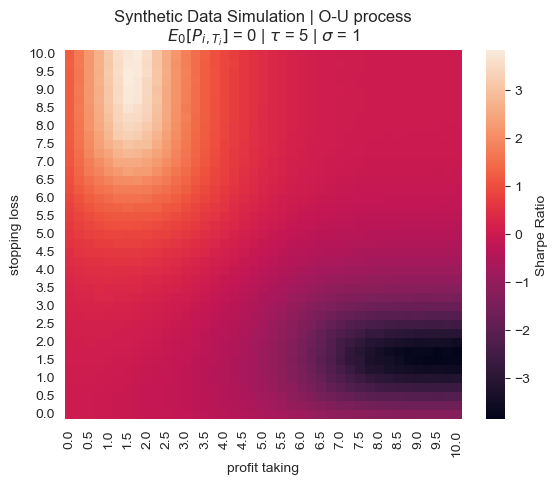

In [4]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

$\tau$를 5에서 10으로 증가시키면 최고와 최저 성과의 영역이 쌍의 격자에 흩어지고, Sharpe Ratio는 감소한다는 것을 보여 준다. 이는 반감기가 증가할수록 자기 회귀 계수의 크기도 증가한다. 따라서 프로세스가 랜덤에 가까워지게 한다.

In [5]:
coeffs = {'forecast': 0, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

In [6]:
output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

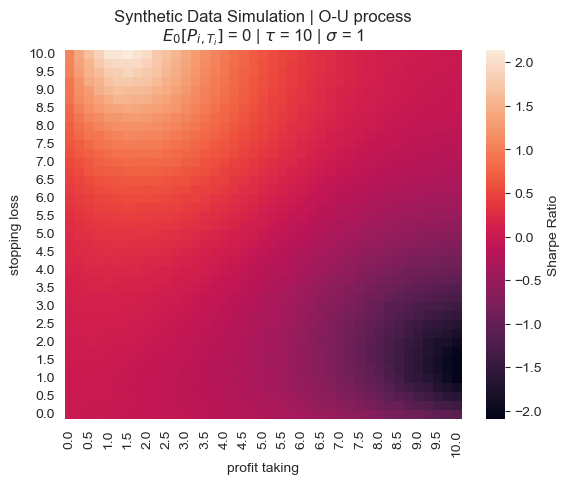

In [7]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

$\tau = 25$인데 또 다시 최고, 최저 성과가 분산되고, Sharpe Ratio는 감소한다. $\tau = 50, \tau = 100$에서 진행을 계속한다. 궁극적으로 $\varphi \rightarrow 1$일수록 성과가 최대화될 영역이 사라지게 된다.

In [8]:
coeffs = {'forecast': 0, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

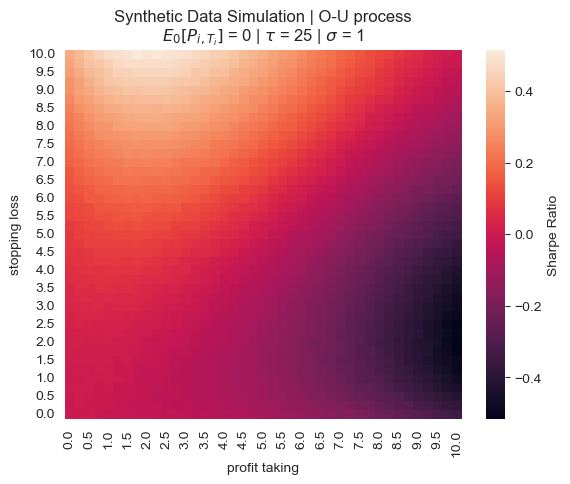

In [9]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [10]:
coeffs = {'forecast': 0, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

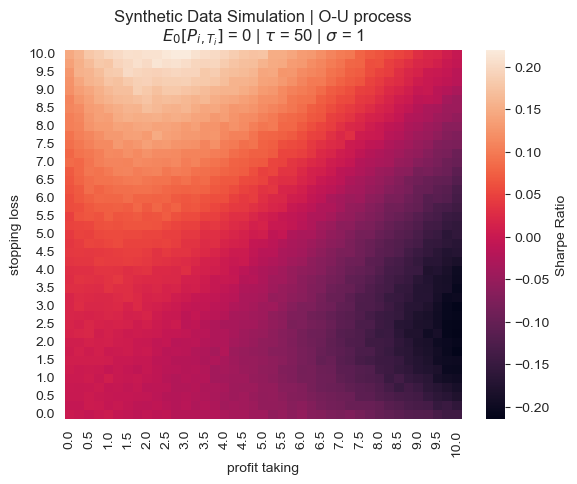

In [11]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [12]:
coeffs = {'forecast': 0, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

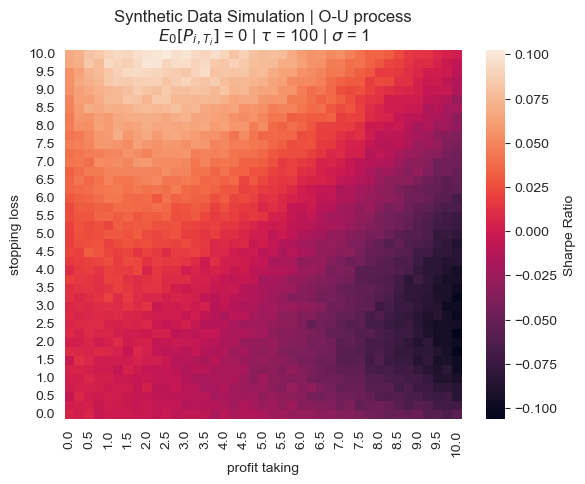

In [13]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

역사적 시뮬레이션에서 랜덤 워크의 거래 규칙을 조율하면 백테스트 과적합이 발생할 수 있다. 우연히 Sharpe ratio를 최대화하는 랜덤 조합의 profit taking과 loss cut이 선택되기 때문이다. 그러므로 synthetic data backtest가 매우 중요하다. 즉, 과거에 발생한 어떤 통계적 요행에 의존해 전략을 선택하는 것을 피한다. 위 실험에서 성과가 일관된 패턴을 보이지 않으면 Optimal Trading Rule이 존재하지 않는다는 것을 나타내므로 과적합을 방지할 수 있다.

#### 양의 장기 균형의 경우

양의 장기 균형은 헤지 펀드나 자산 운용사와 같은 포지션 보유 투자자의 비즈니스와 일치한다. 아래의 그림은 파라미터 조합 $\{E_0 [P_{i,T_i}], \tau, \sigma\} = \{5, 5, 1\}$의 결과를 보여 준다. 포지션들이 수익을 내는 경향이 있기 때문에, 최적 이익 실현은 이전 경우보다 높고, 6근처에 머물러 있으며, loss cut은 4와 10 사이에 있다. 최적 거래 규칙은 넓은 loss cut 구간과 profit taking 구간이 결합된 직사각형 모양을 하고 있다. 성과는 모든 실험 중 최고값이고, Sharpe Ratio는 12 가까이 된다.

In [14]:
coeffs = {'forecast': 5, 'hl': 5, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

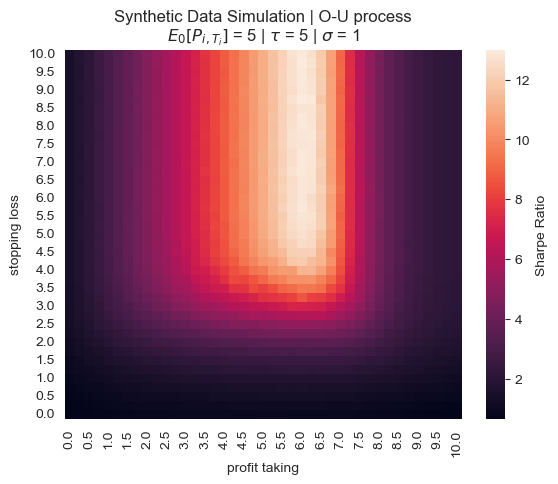

In [15]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

이번에는 반감기를 $\tau = 5$에서 $\tau = 10$으로 증가시켰다. 이제 최적 성과는 5 근처에 집중된 이익 실현과 7과 10 사이에 분포한 손실에서 얻어진다. 최적 이익 실현 범위는 넓어졌지만 최적 손실은 좁아졌고, 이전의 직사각형은 정사각형에 가깝게 바뀌었다. 다시 말해, 반감기가 더 커지면 랜덤워크에 더 가까워지므로 성과는 이제 예전보다 낮아지고, Sharpe Ratio는 9에 육박한다.

In [16]:
coeffs = {'forecast': 5, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

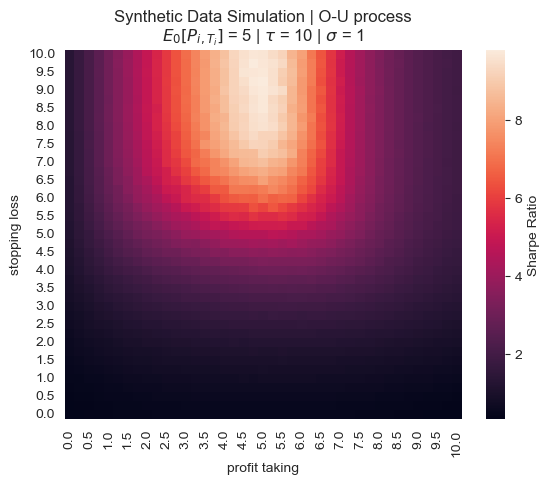

In [17]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

이제 반감기를 $\tau = 25$로 해 보자. 최적 이익 실현값은 이제 3 근처에 몰려 있고, 최적 손실은 9와 10 사이에 있다. 이전 최적 성과의 정사각형 영역은 작은 이익 실현과 큰 손실 임계값을 가진 반원처럼 됐다. 다시 여기서 성과의 저하를 보게 된다. Sharpe Ratio는 2.7이다.

In [18]:
coeffs = {'forecast': 5, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

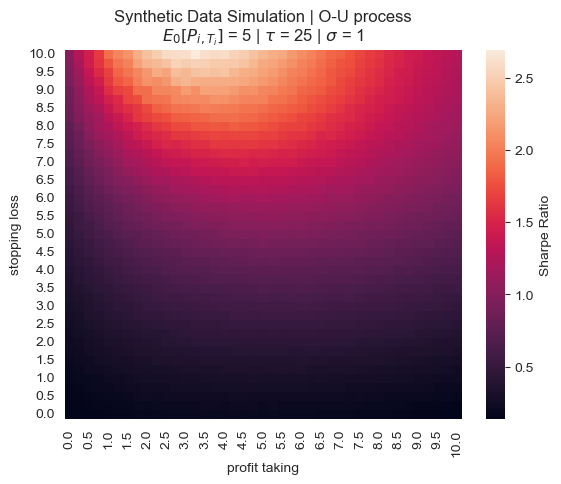

In [19]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

반감기가 $\tau = 50$인 경우로 증가했다. 그 결과, 최적 영역은 흩어지고 Sharpe Ratio는 계속 떨어져 0.8이 되었다. 이는 제로 장기 균형 경우를 관찰 했을 때와 동일하다. 차이점은 이제 $E_0 [P_{i,T_i}] > 0$이기 때문에 최악 성과의 대칭 영역이 없다는 것이다.

In [20]:
coeffs = {'forecast': 5, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

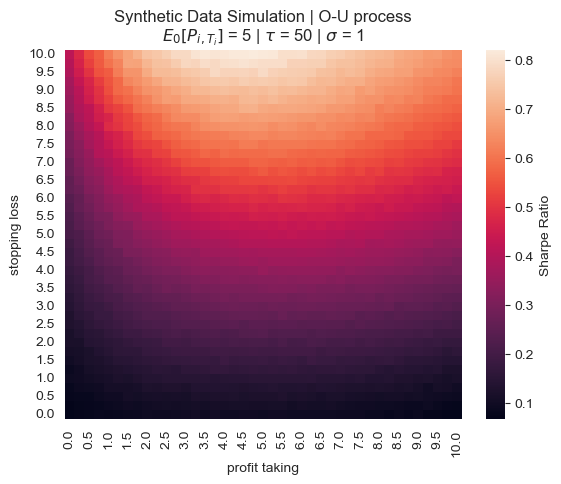

In [21]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

반감기가 $\tau = 100$인 경우 앞에서 설명한 경향이 자연스럽게 이어진다는 것을 알 수 있다. 시계열 프로세스는 이제 랜덤 워크에 무척 가까워져서 최대 Sharpe Ratio는 겨우 0.32이다. 

In [22]:
coeffs = {'forecast': 5, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

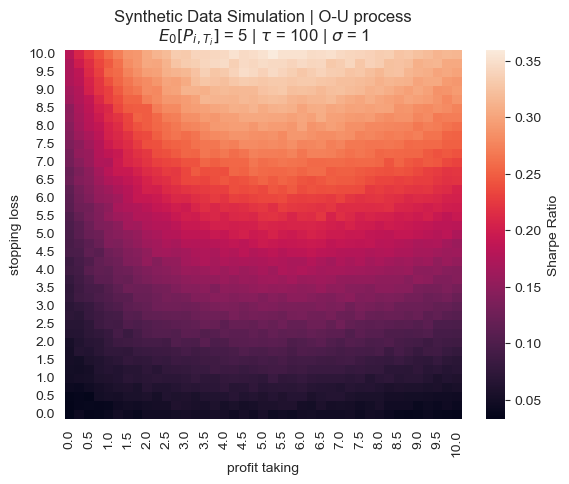

In [23]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

아래의 그림에서도 이와 비슷한 경향을 관찰할 수 있는데, $E_0[P_{i, T_i}] = 10$이고, $\tau$는 점진적으로 5부터 10, 25, 50, 100으로 각각 증가한다.

In [24]:
coeffs = {'forecast': 10, 'hl': 5, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

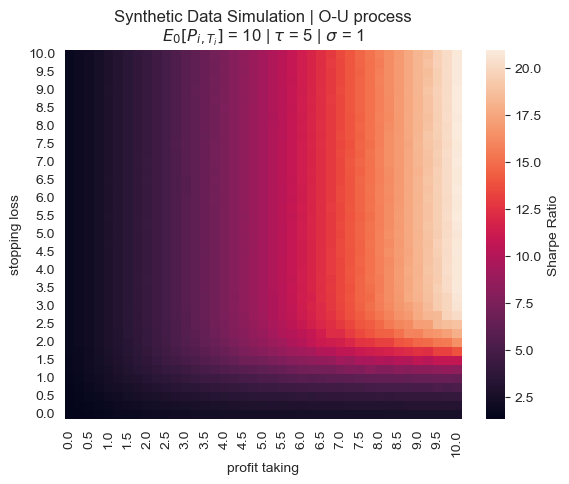

In [25]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [26]:
coeffs = {'forecast': 10, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

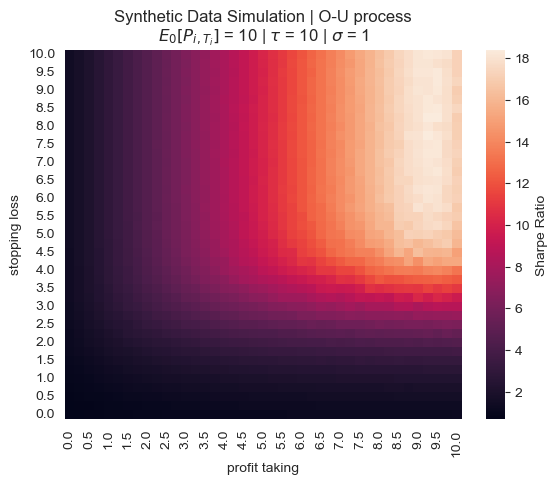

In [27]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [28]:
coeffs = {'forecast': 10, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

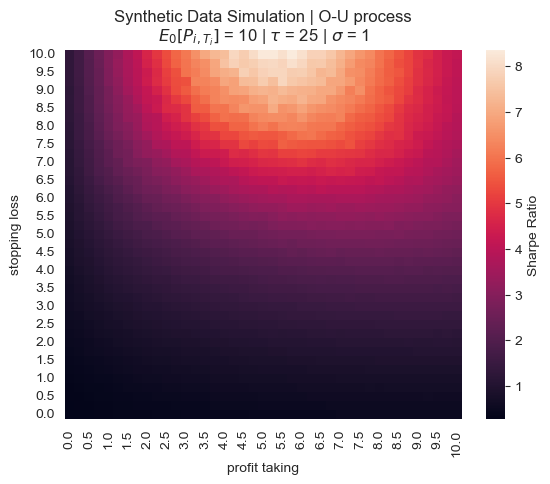

In [29]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [30]:
coeffs = {'forecast': 10, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

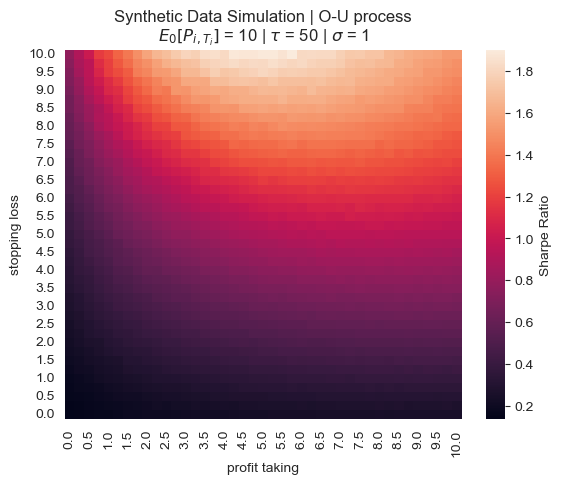

In [31]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [32]:
coeffs = {'forecast': 10, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

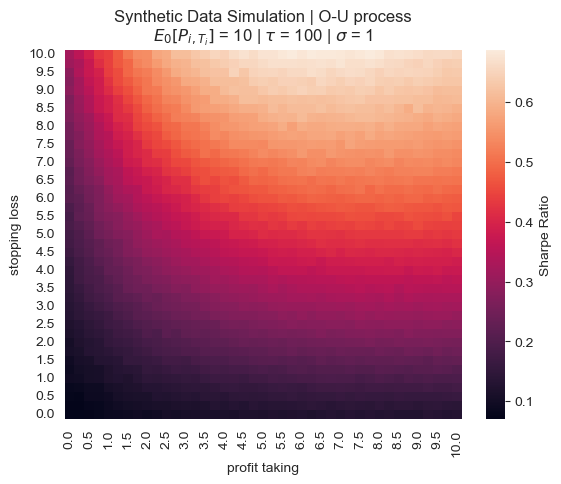

In [33]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

#### 음의 장기 균형의 경우

합리적 시장 참여자라면 기대 결과가 손실인 가정하에서는 포지션을 제시하지 않을 것이다. 그러나 거래자가 손실이 기존 포지션 결과의 기대값이라는 것을 인식하면 거래자는 어떤 손실을 최소화하면서 포지션을 중단할 수 있는 전략을 필요로 할 것이다. 아래의 그림은 파라미터 조합 $\{E_0 [P_{i,T_i}], \tau, \sigma\} = \{-5, 5, 1\}$을 적용한 결과이다. 양의 균형일 때와 비교하였을 때 거의 결과를 뒤집은 결과처럼 나오는데, 이는 매수자의 수익이 매도자의 손실이 되는 매커니즘을 보여주는 것과 같다.

In [34]:
coeffs = {'forecast': -5, 'hl': 5, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

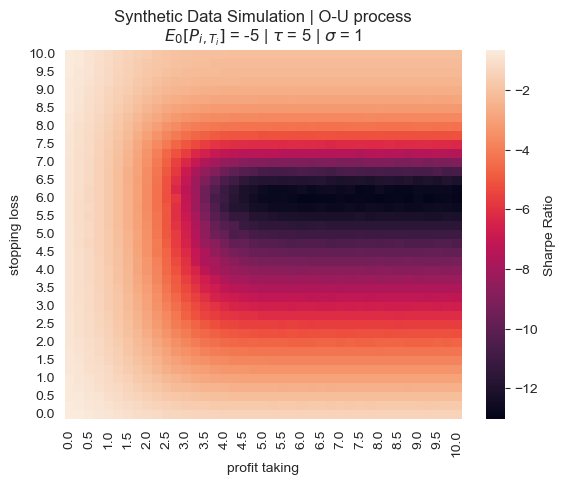

In [35]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -5 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

에상한 대로 Sharpe Ratio는 음수이고, 최악 성과 영역은 loss cut이 6사이에 몰려 있으며, profit taking 임계값은 4부터 10사이에 분포하고 있다. 이제 직사각형 모양은 최적 성과 영역에 해당하지 않고 최악 성과 영역에 해당하며, Sharpe Ratio는 약 -12이다. $\tau = 10$이고 랜덤워크에 가까운 것은 우리가 원하는 결과와 맞아 들어간다. 최악 성과 영역은 분산되고, 직사각형 영역은 정사각형이 된다. 성과 정도는 손실이 줄어들었으며, Sharpe Ratio는 약 -9이다.

In [36]:
coeffs = {'forecast': -5, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

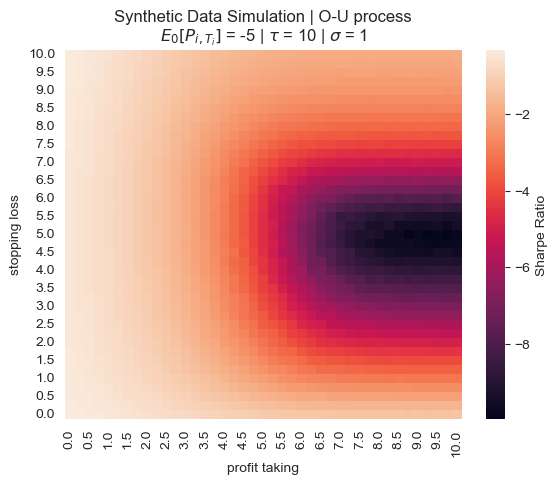

In [37]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -5 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

이 익숙한 진행은 $\tau$가 25, 50, 100으로 증가하면서 반복된다. 다시 말해 프로세스가 랜덤 워크로 갈수록 성과는 평탄해지고 거래 규칙 최적화는 백테스팅 과적합 연습이 된다.

In [38]:
coeffs = {'forecast': -5, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

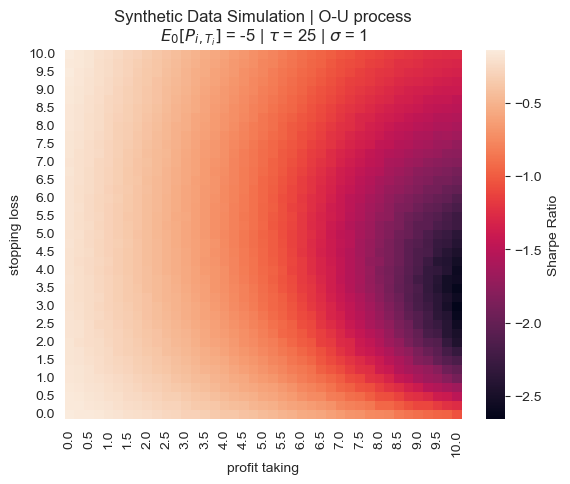

In [39]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -5 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [40]:
coeffs = {'forecast': -5, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

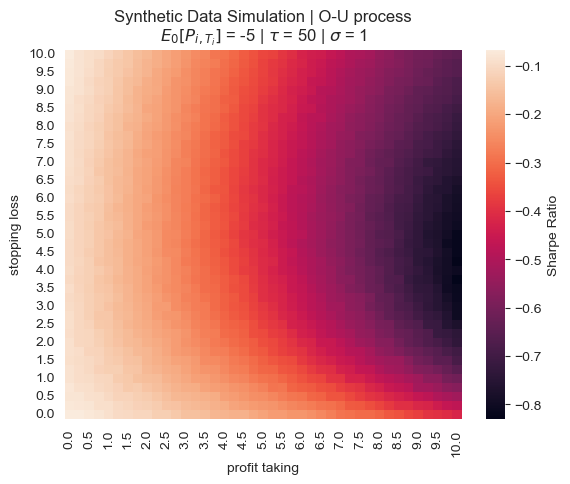

In [41]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -5 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [42]:
coeffs = {'forecast': -5, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

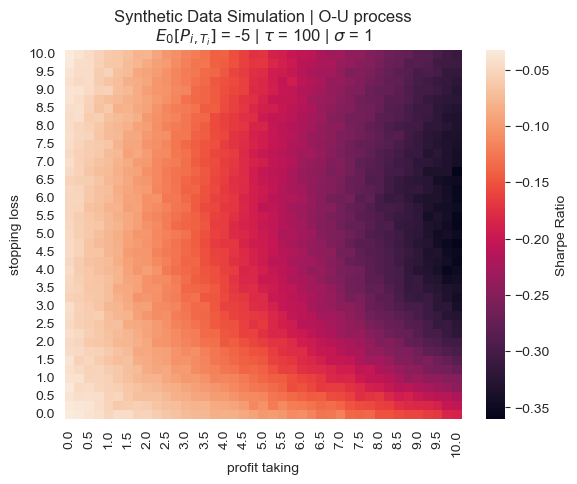

In [43]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -5 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

아래 일련의 그림들은 동일한 프로세스를 $E_0[P_{i, T_i}] = -10$과 $\tau$를 5부터 10, 25, 50, 100으로 점진적으로 증가시키면서 반복한다. 양의 장기 균형에서 발생했던 회전된 보완 패턴과 동일한 것이 나타나는 것을 볼 수 있다.

In [44]:
coeffs = {'forecast': -10, 'hl': 5, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

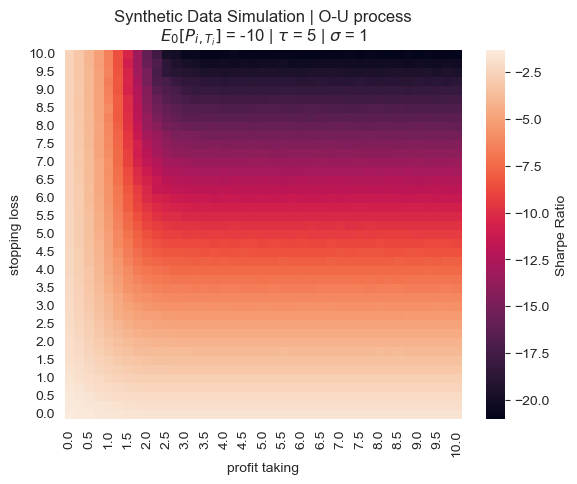

In [45]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -10 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [46]:
coeffs = {'forecast': -10, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

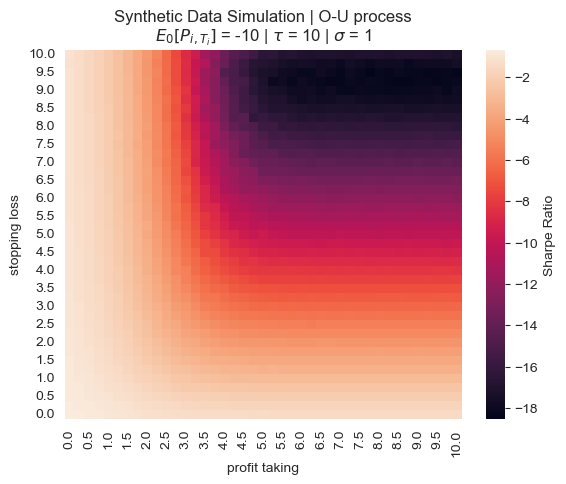

In [47]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -10 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [48]:
coeffs = {'forecast': -10, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

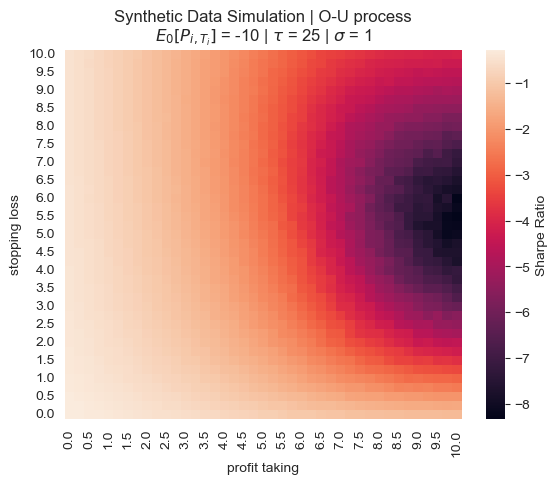

In [49]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -10 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [50]:
coeffs = {'forecast': -10, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

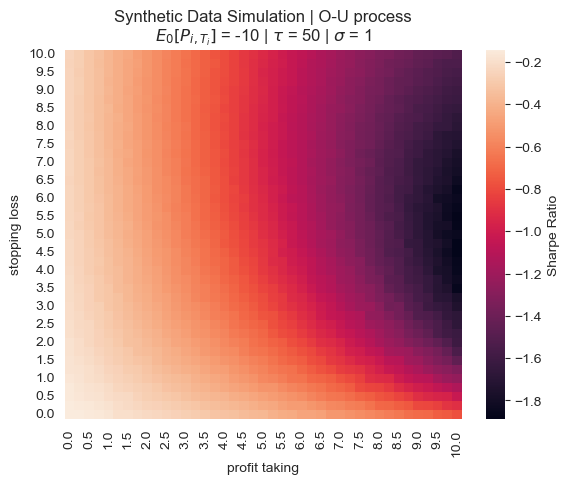

In [51]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -10 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [52]:
coeffs = {'forecast': -10, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

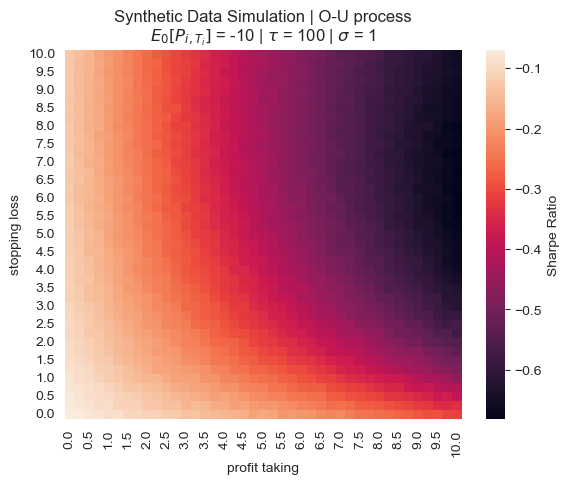

In [53]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = -10 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

### Conclusion

이번 장에서는 Discrete Ornstein-Uhlenbeck Process를 따르는 가격에 연관된 최적 거래 전략을 실험적으로 결정하는 방법을 알아보았다. 이런 거래 전략 도출은 역사적 시뮬레이션의 결과가 아니므로, 절차는 단일 경로로 백테스트가 과적합되는 리스크를 피했다. 그 대신 최적 거래 전략은 가격을 주도하는 기저 확률 프로세스의 특성으로부터 도출했다. 동일한 접근 방법이 Ornstein-Uhlenbeck Process 이외에도 적용 가능하지만, 교육적 목적만을 위해 이 프로세스에만 집중하였다. 여기서는 최적 거래 전략 문제 해결을 위한 닫힌 해를 유도하지 않았지만, 여기의 실험 결과는 다음의 OTR(Optimal Trading Rule) 추측을 뒷받침한다.

> 추측 : Discrete Ornstein-Uhlenbeck Process에 의해 가격이 특징지어진 금융 상품이 주어질 때, Sharpe Ratio를 최대화하는 이익 실현과 손실 조합의 표현으로 유일한 Optimal Trading Rule이 존재한다.

이런 OTR을 몇 초 내에 수치적으로 도출될 수 있으므로 굳이 닫힌 해를 얻어야 할 실익이 크지 않다. 수학적 연구 분야에서 더욱 보편화되는 경향처럼 추측의 실험적 분석은 증명 없이도 목표를 성취하는 데 도움을 준다. 앞의 추측을 증명하려면 몇 십 년은 아니더라도 몇 년은 걸릴지 모른다. 그리고 현재까지 수행된 모든 실험이 실증적으로 이를 증명해 주고 있다. 이 추측이 틀릴 확률은 추측을 무시해 거래 규칙을 과적합화할 확률에 비하면 무시할 만한다. 그러므로, 합리적 행동 방향은 추측이 옳다고 가정하고 합성 데이터를 통해 OTR을 결정하는 것이다. 최악의 경우 거래 규칙이 최적이 아닐 수 있지만, 여전히 거의 확실히 과적합화된 거래 규칙보다 뛰어난 성과를 발휘할 것이다.